In [1]:
%matplotlib inline

In [2]:
import itertools
import math
import time

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable

### Load Dataset

In [3]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

BATCH_SIZE = 20

import os

from myomniglot import MyOmniglot

setname = 'images_background'

train_dataset = MyOmniglot(root='./data', setname=setname, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

### Model

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(105 * 105, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), 105 * 105))
        out = out.view(out.size(0), -1)
        return out

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(BATCH_SIZE, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 105 * 105),
            nn.Tanh()
        )
    
    def forward(self, x):
        
        x = x.view(x.size(0), BATCH_SIZE)
        out = self.model(x)
        return out

### Optimization

### Training

In [6]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [7]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [9]:
import os

dirlist = []

root = './data_generated/omniglot-py/' + setname

for language in os.listdir(root):
    for character in os.listdir(root + '/' + language):
        characterDir = root + '/' + language + '/' + character
        dirlist.append(characterDir)
    

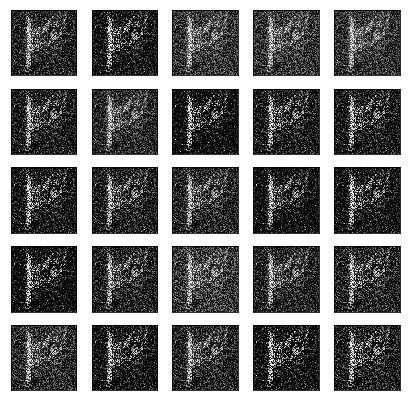

Epoch [301/601], Step[1/964], d_loss: 0.4872, g_loss: 5.2022, D(x): 0.99, D(G(z)): 0.29
./generated/omniglot/python/images_background/Anglo-Saxon_Futhorc/character01


/home/qweenink/.local/lib/python3.5/site-packages/ipykernel_launcher.py:97: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


KeyboardInterrupt: 

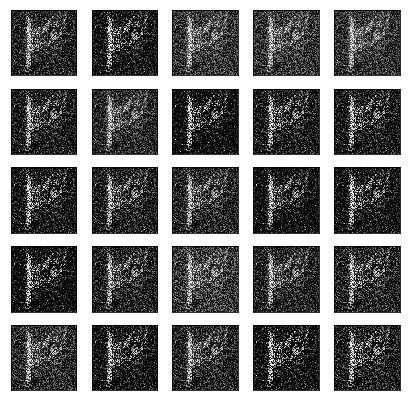

In [10]:
import scipy.misc

size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(7, 7))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    
num_epochs = 601
num_batches = len(train_loader)
num_fig = 0

MINIBATCH_SIZE = 5
lr = 0.0002

ENABLE_CUDA = False



for n, (characterSet, _) in enumerate(train_loader):
    saveDir = dirlist[n]
    
    if ENABLE_CUDA:
        discriminator = Discriminator().cuda()
        generator = Generator().cuda()
    else:
        discriminator = Discriminator()
        generator = Generator()
        
    criterion = nn.BCELoss()
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
    
    plt.imshow(characterSet[0][0].data.cpu().numpy().reshape(105, 105), cmap='Greys')

    for epoch in range(num_epochs):
        idx = torch.randperm(characterSet.size(0))[:MINIBATCH_SIZE]
        if ENABLE_CUDA:
            images = Variable(characterSet[idx].cuda())
            real_labels = Variable(torch.ones(images.size(0)).cuda())
        else:
            images = Variable(characterSet[idx])
            real_labels = Variable(torch.ones(images.size(0)))

        # Sample from generator
        if ENABLE_CUDA:
            noise = Variable(torch.randn(images.size(0), BATCH_SIZE).cuda())
            fake_images = generator(noise)
            fake_labels = Variable(torch.zeros(images.size(0)).cuda())
        else:
            noise = Variable(torch.randn(images.size(0), BATCH_SIZE))
            fake_images = generator(noise)
            fake_labels = Variable(torch.zeros(images.size(0)))

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)

        # Sample again from the generator and get output from discriminator
        if ENABLE_CUDA:
            noise = Variable(torch.randn(images.size(0), BATCH_SIZE).cuda())
        else:
            noise = Variable(torch.randn(images.size(0), BATCH_SIZE))
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)

        if epoch % 100 == 0:
            if ENABLE_CUDA:
                test_images = generator(Variable(torch.randn(num_test_samples, BATCH_SIZE).cuda()))
            else:
                test_images = generator(Variable(torch.randn(num_test_samples, BATCH_SIZE)))
            for k in range(num_test_samples):
                i = k//5
                j = k%5
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(105, 105), cmap='Greys')

            display.clear_output(wait=True)
            display.display(plt.gcf())

            #plt.savefig('results/gan-%d.png'%epoch)
            num_fig += 1
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))
            print(saveDir)
            
            
            if epoch != 0 and epoch != 100 and epoch != 200:
                for save in range(5):
                    image = test_images[save].cpu().detach().numpy().reshape(105, 105)
                    thresh = np.mean(image)
                    binary = np.array([[1 if y > thresh else 0 for y in x] for x in image])
                    scipy.misc.toimage(binary).save(saveDir + '/' + 'generated' + str(int(epoch/100)) + '-' + str(save) + '.jpg')


In [ ]:
torch.save(generator, 'generator.pt')
torch.save(discriminator, 'discriminator.pt')